The model incorrectly predicts class 463 instead of class 0 of the flower from the Oxford-17 flower dataset.


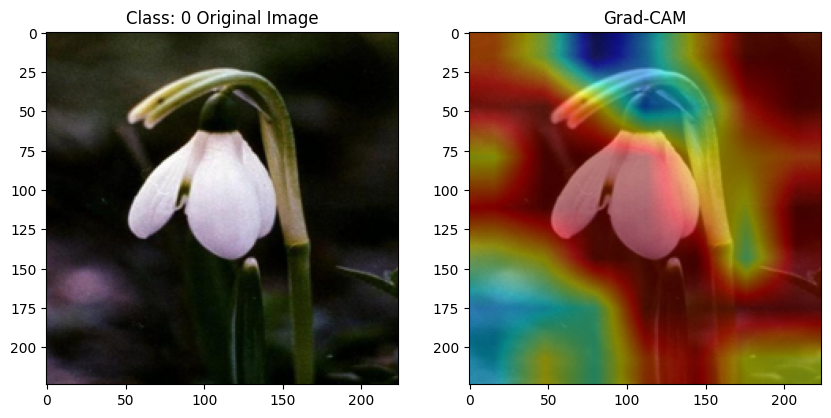

The model incorrectly predicts class 463 instead of class 1 of the flower from the Oxford-17 flower dataset.


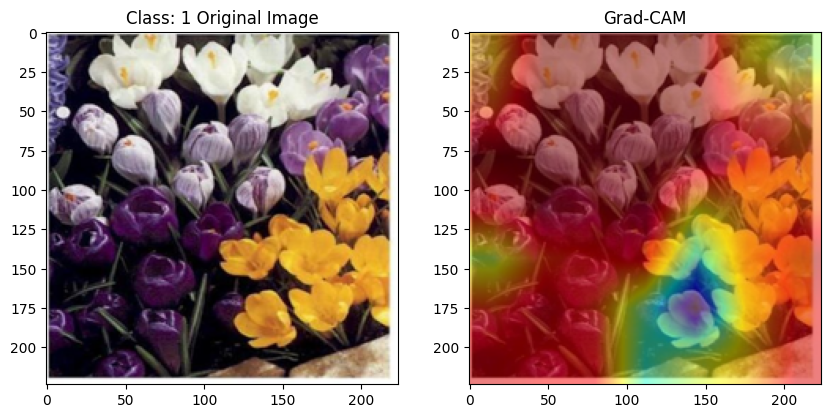

The model incorrectly predicts class 463 instead of class 2 of the flower from the Oxford-17 flower dataset.


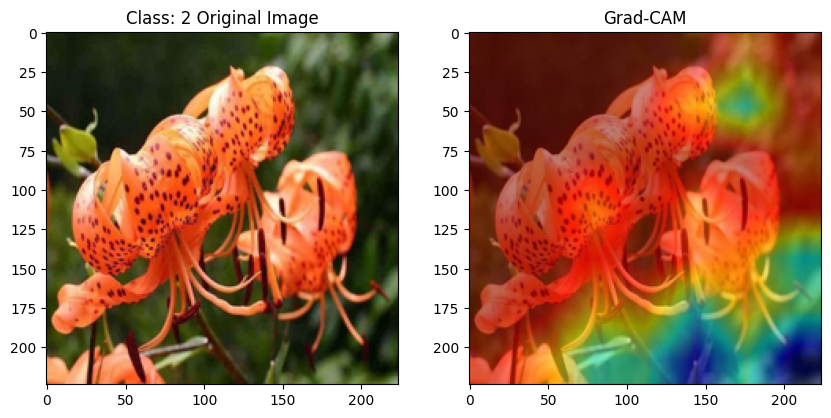

The model incorrectly predicts class 463 instead of class 3 of the flower from the Oxford-17 flower dataset.


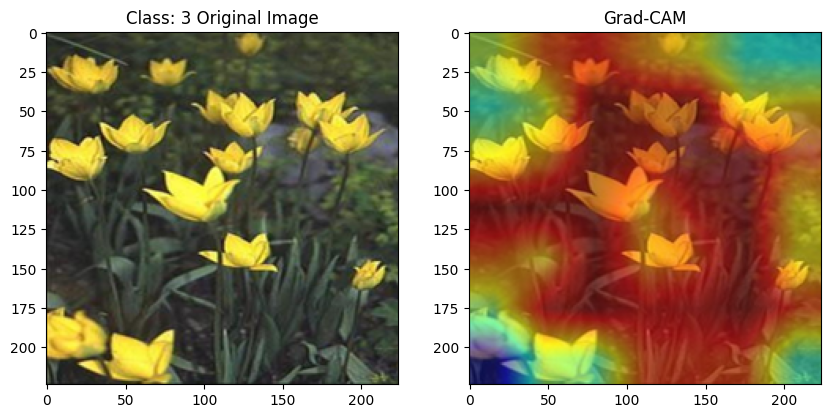

The model incorrectly predicts class 600 instead of class 4 of the flower from the Oxford-17 flower dataset.


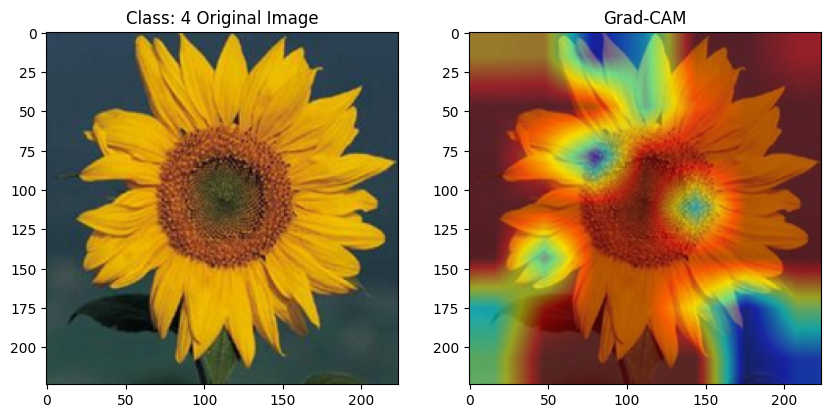

The model incorrectly predicts class 463 instead of class 5 of the flower from the Oxford-17 flower dataset.


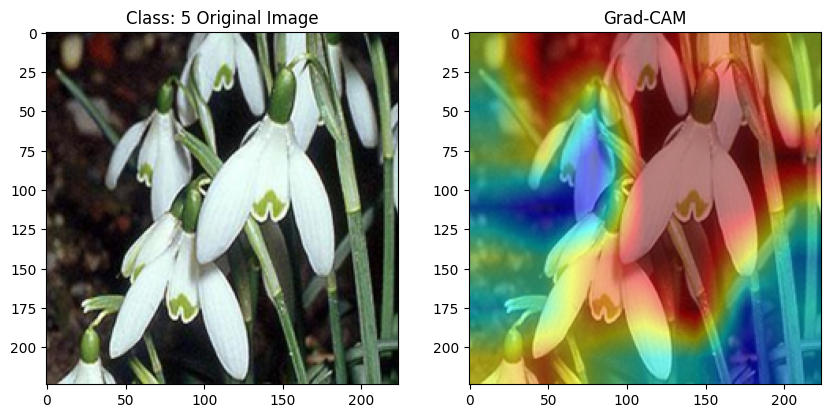

The model incorrectly predicts class 463 instead of class 6 of the flower from the Oxford-17 flower dataset.


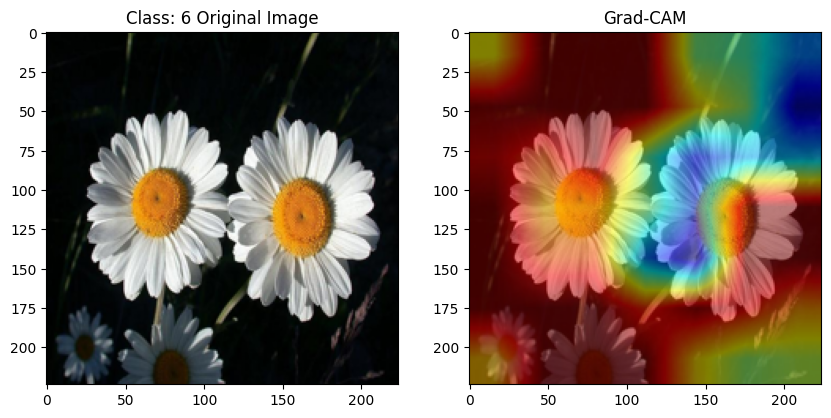

The model incorrectly predicts class 600 instead of class 7 of the flower from the Oxford-17 flower dataset.


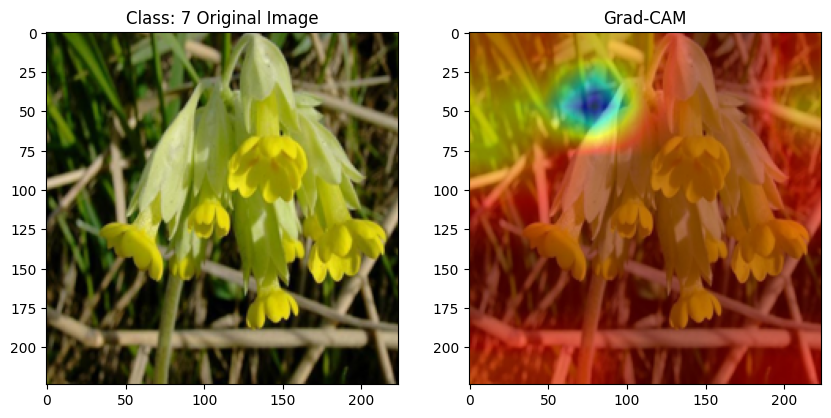

The model incorrectly predicts class 463 instead of class 8 of the flower from the Oxford-17 flower dataset.


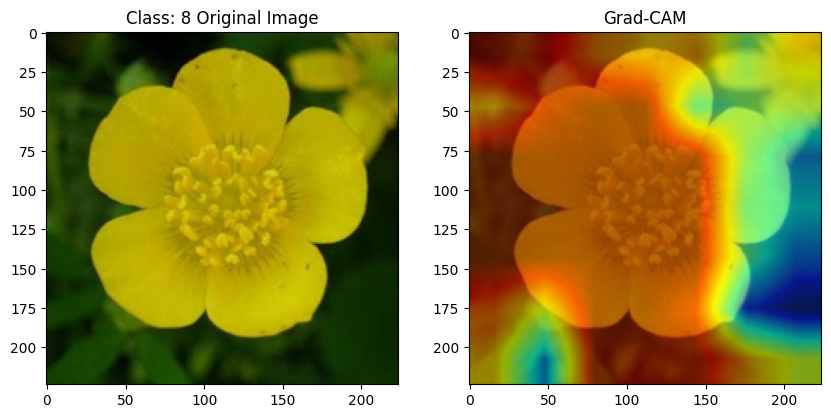

The model incorrectly predicts class 463 instead of class 9 of the flower from the Oxford-17 flower dataset.


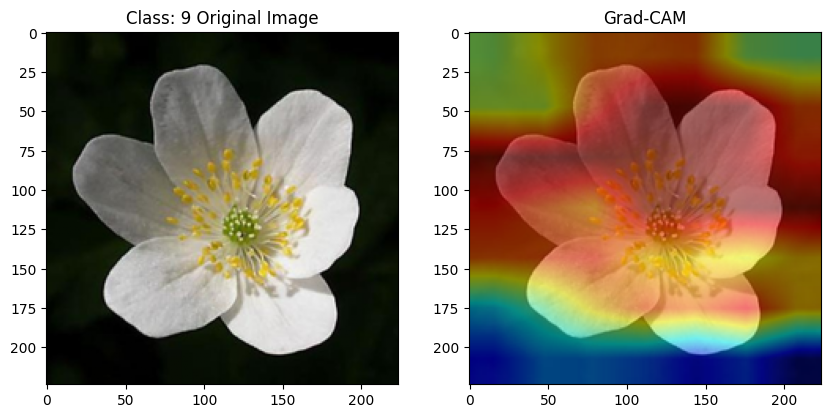

The model incorrectly predicts class 463 instead of class 10 of the flower from the Oxford-17 flower dataset.


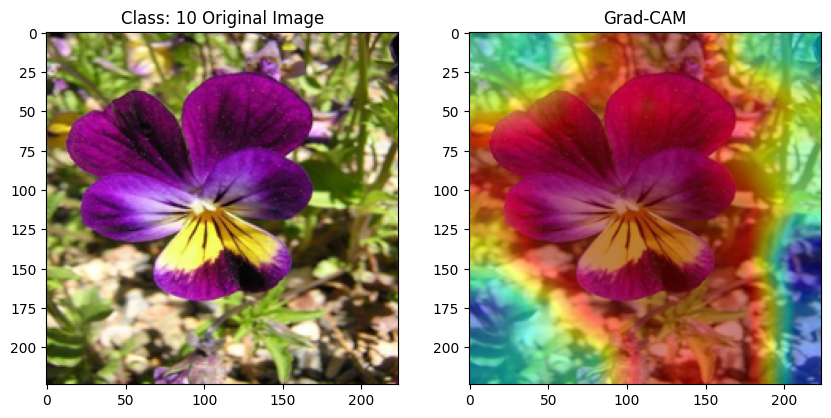

The model incorrectly predicts class 463 instead of class 11 of the flower from the Oxford-17 flower dataset.


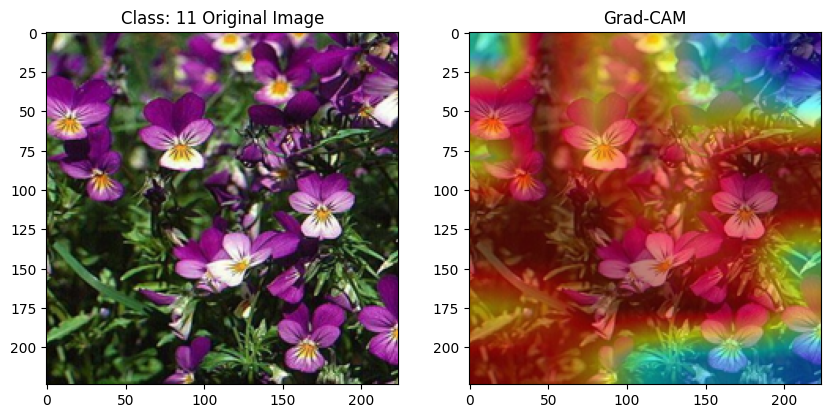

The model incorrectly predicts class 463 instead of class 12 of the flower from the Oxford-17 flower dataset.


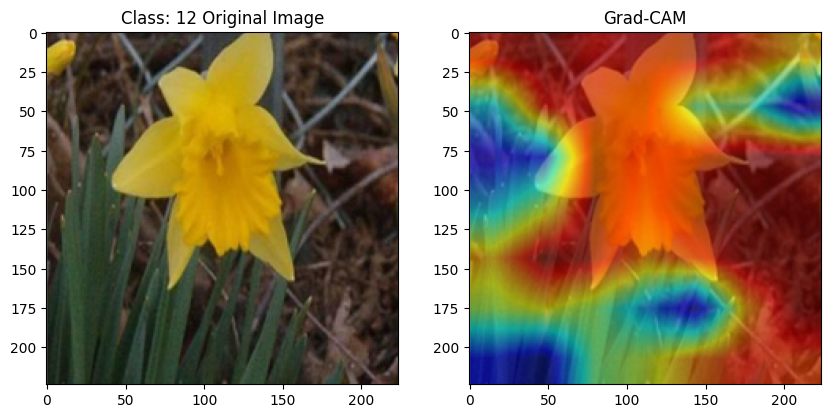

The model incorrectly predicts class 463 instead of class 13 of the flower from the Oxford-17 flower dataset.


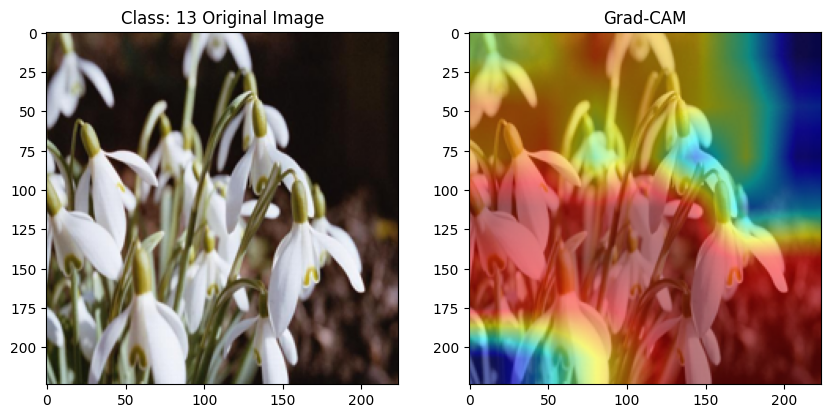

The model incorrectly predicts class 463 instead of class 14 of the flower from the Oxford-17 flower dataset.


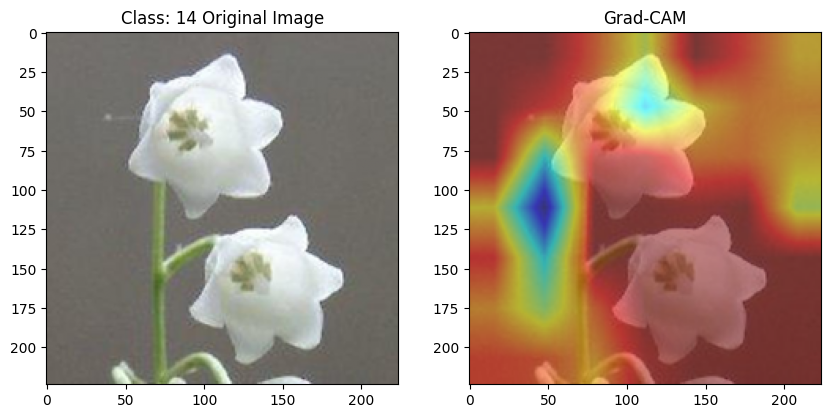

The model incorrectly predicts class 600 instead of class 15 of the flower from the Oxford-17 flower dataset.


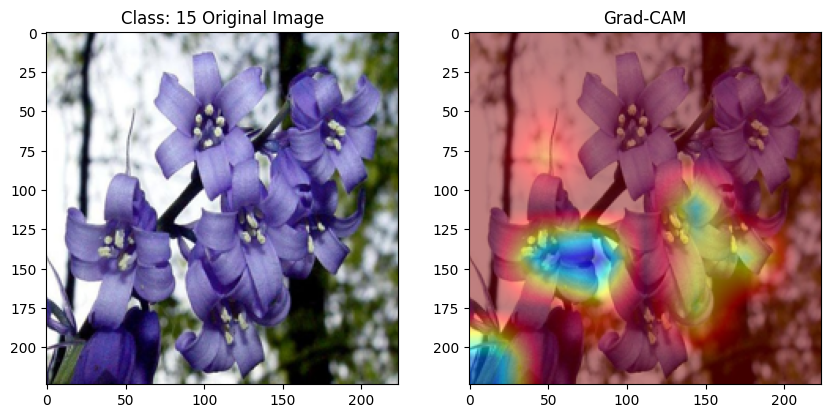

The model incorrectly predicts class 463 instead of class 16 of the flower from the Oxford-17 flower dataset.


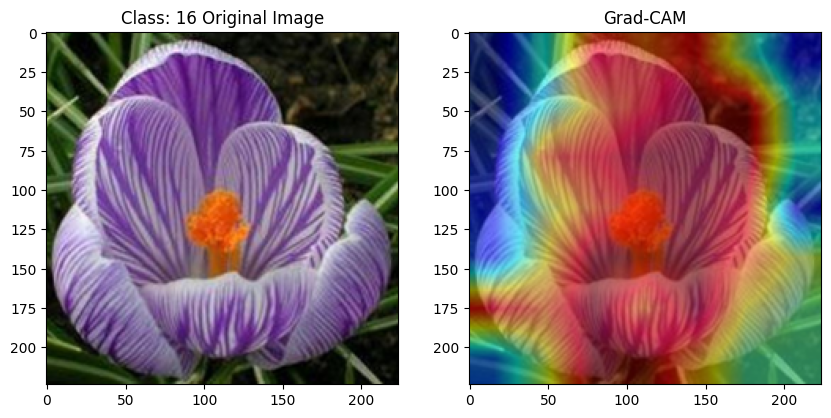

In [31]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

def preprocess_image(image_path, input_size):
    preprocess = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    return preprocess(image).unsqueeze(0)

def show_cam_on_image(image, mask):
    # Ensure the mask is 2D and resize it to match the image dimensions
    mask = cv2.resize(mask, (image.shape[1], image.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(image)
    cam = cam / np.max(cam)  # Normalize
    return np.uint8(255 * cam)

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

        target_layer.register_forward_hook(self.save_features)
        target_layer.register_backward_hook(self.save_gradients)

    def save_features(self, module, input, output):
        self.features = output

    def save_gradients(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def generate(self, input_tensor, target_class):
        output = self.model(input_tensor)
        self.model.zero_grad()
        target = output[0, target_class]
        target.backward()

        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        cam = torch.sum(weights * self.features, dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = cam.squeeze().detach().cpu().numpy()
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize
        return cam

# Load pre-trained model
model = models.resnet50(pretrained=True)

# Select target layer
target_layer = model.layer4[2].conv3

# Initialize Grad-CAM
grad_cam = GradCAM(model, target_layer)

# Define input size for images and paths to the Oxford-17 Flower dataset
input_size = (224, 224)
flower_paths = [
    r"C:\Users\admin\Documents\126156072\17flowers (1)\jpg\image_0084.jpg",
    r"C:\Users\admin\Documents\126156072\17flowers (1)\jpg\image_0396.jpg",
    r"C:\Users\admin\Documents\126156072\17flowers (1)\jpg\image_0482.jpg",
    r"C:\Users\admin\Documents\126156072\17flowers (1)\jpg\image_0614.jpg",
    r"C:\Users\admin\Documents\126156072\17flowers (1)\jpg\image_0741.jpg",
    r"C:\Users\admin\Documents\126156072\17flowers (1)\jpg\image_0103.jpg",
    r"C:\Users\admin\Documents\126156072\17flowers (1)\jpg\image_0855.jpg",
    r"C:\Users\admin\Documents\126156072\17flowers (1)\jpg\image_1052.jpg",
    r"C:\Users\admin\Documents\126156072\17flowers (1)\jpg\image_1124.jpg",
    r"C:\Users\admin\Documents\126156072\17flowers (1)\jpg\image_1201.jpg",
    r"C:\Users\admin\Documents\126156072\17flowers (1)\jpg\image_1291.jpg",
    r"C:\Users\admin\Documents\126156072\17flowers (1)\jpg\image_1356.jpg",
    r"C:\Users\admin\Documents\126156072\17flowers (1)\jpg\image_0011.jpg",  
    r"C:\Users\admin\Documents\126156072\17flowers (1)\jpg\image_0137.jpg",  
    r"C:\Users\admin\Documents\126156072\17flowers (1)\jpg\image_0162.jpg",  
    r"C:\Users\admin\Documents\126156072\17flowers (1)\jpg\image_0252.jpg",  
    r"C:\Users\admin\Documents\126156072\17flowers (1)\jpg\image_0330.jpg"
]

# Preprocess the input images
for i in range(len(flower_paths)):
    image_path = flower_paths[i]
    input_tensor = preprocess_image(image_path, input_size)

    # Generate Grad-CAM
    output = model(input_tensor)
    predicted_class = torch.argmax(output).item()
    cam = grad_cam.generate(input_tensor, predicted_class)

    # Visualize the result
    original_image = Image.open(image_path).convert("RGB")
    original_image = np.array(original_image.resize(input_size)) / 255.0
    cam_image = show_cam_on_image(original_image, cam)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Class: {}".format(i) + " Original Image")
    if i == predicted_class:
        print(f"The model correctly predicts the class {i} of the flower from the  Oxford-17 flower dataset.")
    else:
        print(f"The model incorrectly predicts class {predicted_class} instead of class {i} of the flower from the Oxford-17 flower dataset.")
    plt.imshow(original_image)

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM")
    plt.imshow(cam_image)
    plt.show()
